In [1]:
import numpy as np, h5py
from PIL import Image
import sys
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from utils.processing import *
from utils.template_match_target import *
import os
%matplotlib inline

def pix2coord(x, y, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    long = (x / float(pixbd[0])) * (llbd[1] - llbd[0]) + llbd[0]
    lat = llbd[3] - (y / float(pixbd[1])) * (llbd[3] - llbd[2])
    return long, lat

## Plot crater dists

In [2]:
# Open image, inport crater files
img_global = Image.open('tests/LunarLROLrocKaguya_1180mperpix_downsamp.png').convert("L")
#img_global = Image.open('../moon-craters/utils/LunarLROLrocKaguya_118mperpix.png').convert("L")

In [49]:
def get_stats(pred, csv_coords, thresh_longlat2, thresh_rad2, radcut):
    pred = pred[pred.T[2] > radcut]
    
    csv_duplicates, new_craters = [], []
    N_match, err_lo, err_la, err_r, beta = 0, 0, 0, 0, 1
    N_csv, N_detect = len(csv_coords), len(pred)
    km_to_deg = 180. / (np.pi * 1737.4)
    for lo, la, r in pred:
        Long, Lat, Rad = csv_coords.T
        
        diff_longlat = ((Long - lo)**2 + (Lat - la)**2) / (r * km_to_deg)**2
        index = (diff_longlat < thresh_longlat2) & (((Rad - r) / r)**2 < thresh_rad2)
        index_True = np.where(index == True)[0]
        N = len(index_True)
        if N > 1:
            cratervals = np.array((lo, la, r))
            id_keep = index_True[0]
            diff = np.sum((csv_coords[id_keep] - cratervals)**2)
            csv_duplicates.append(csv_coords[id_keep])
            for id in index_True[1:]:
                dupevals = csv_coords[id]
                index[id] = False
                csv_duplicates.append(dupevals)
                diff_ = np.sum((dupevals - cratervals)**2)
                if diff_ < diff:
                    id_keep = id
                    diff = diff_
            index[id_keep] = True       # keep only closest match as true
            Lo, La, R = csv_coords[id_keep].T
            err_lo += abs(Lo - lo) / (r * km_to_deg)
            err_la += abs(La - la) / (r * km_to_deg)
            err_r += abs(R - r) / r
        elif N == 1:
            Lo, La, R = csv_coords[index_True[0]].T
            err_lo += abs(Lo - lo) / (r * km_to_deg)
            err_la += abs(La - la) / (r * km_to_deg)
            err_r += abs(R - r) / r
        else:
            new_craters += [(lo, la, r)]
        N_match += min(1, N)
        # remove csv so it can't be re-matched again
        csv_coords = csv_coords[np.where(index == False)]
        if len(csv_coords) == 0:
            break

    p = float(N_match) / float(N_match + (N_detect - N_match))
    r = float(N_match) / float(N_csv)
    f = (1 + beta**2) * (r * p) / (p * beta**2 + r)
    print("For this image:")
    print("precision: %.3f, recall=%.3f, f1=%.3f"%(p,r,f))
    print("long_err=%.3f, lat_err=%.3f, rad_err=%.3f"%(err_lo/N_detect, err_la/N_detect, err_r/N_detect))
    print("frac_new_craters=(N_detect-N_match)/N_csv=%.3f"%((N_detect - N_match)/float(N_csv)))
    
    return np.asarray(new_craters)

In [63]:
def coord2pix(long, lat, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    x = (long - llbd[0]) / (llbd[1] - llbd[0]) * pixbd[0]
    y = (llbd[3] - lat) / (llbd[3] - llbd[2]) * pixbd[1]
    return x, y

def cropcraters(craters, llbd):
    return craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                   (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])]

def plot_craters(craters,GT_craters,xc,yc,rawlen,llt2,rt2,mr,i=0,plot_new_only=0):
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='int32')

    img = img_global.crop(box)
    llbd = pix2coord(box[0::2], box[1::2], img_global.size, [-180., 180., -60., 60.])
    print("longlat bounds:",llbd)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    ctrs_sub = cropcraters(craters, llbd)
    GTctrs_sub = cropcraters(GT_craters, llbd)

    x, y = coord2pix(ctrs_sub.T[0], ctrs_sub.T[1], img.size, llbd)
    r = ctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    GTx, GTy = coord2pix(GTctrs_sub.T[0], GTctrs_sub.T[1], img.size, llbd)
    GTr = GTctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    #precision/recall/f1 stats
    new_craters = get_stats(ctrs_sub, GTctrs_sub, llt2, rt2, min(GTctrs_sub.T[2]))
    #plot only new craters
    if plot_new_only == 1:
        x, y, r = new_craters.T
        x, y = coord2pix(x, y, img.size, llbd)
        r = r/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[25, 10])
    plt.tight_layout()
    fontsize = 30
    img = np.asanyarray(img)
    min_, max_ = np.min(img), np.max(img)
    ax1.imshow(img, cmap='Greys_r', vmin=1.2*min_, vmax=max_)
    #ax1.set_title(llbd, fontsize=fontsize)
    ax1.set_title('Moon Image', fontsize=fontsize)
    ax2.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax2.set_title('CNN-Detected Craters', fontsize=fontsize)
    ax3.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax3.set_title('Test Set Craters', fontsize=fontsize)
    for k in range(len(x)):
        circle = plt.Circle((x[k], y[k]), r[k], color='blue', fill=False, linewidth=2, alpha=0.5)
        ax2.add_artist(circle)
    for k in range(len(GTctrs_sub)):
        circle = plt.Circle((GTx[k], GTy[k]), GTr[k], color='red', fill=False, linewidth=2, alpha=0.5)
        ax3.add_artist(circle)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    #plt.savefig('images/llt%s_rt%s_mr%d_xc%d_yc%d_rawlen%d.png'%(llt,rt,mr,xc,yc,rawlen))
    plt.savefig('images/FP_TP_Classification/post_proc/%d.png'%i)
    plt.close()
    
    return ctrs_sub

In [64]:
# get pred
dtype='test'
llt, rt, mr = '1.80', '0.40', '5'
#llt, rt = '0.70', '0.70'     #old/bad one
craters = np.load('../moon-craters/datasets/HEAD/HEAD_%s_craterdist_llt%s_rt%s_mr%s_fin2.npy'%(dtype,llt,rt,mr))

# get GT
truthalan = pd.read_csv('catalogues/LROCCraters.csv')
truthhead = pd.read_csv('catalogues/HeadCraters.csv')
truthhead = truthhead[(truthhead['Lat']>=-60)&(truthhead['Lat']<=60)]
truthalan = truthalan[(truthalan['Lat']>=-60)&(truthalan['Lat']<=60)]
if dtype == 'test':
    truthalan = truthalan[truthalan['Long']>60]        #region of test data
    truthhead = truthhead[(truthhead['Lon']>60)&(truthhead['Diam_km']>20.)]
elif dtype == 'dev':
    truthalan = truthalan[(truthalan['Long']>-60)&(truthalan['Long']<60)]        #region of test data
    truthhead = truthhead[(truthhead['Lon']<60)&(truthhead['Lon']>-60)&(truthhead['Diam_km']>20.)]

rad = np.concatenate((truthalan['Diameter (km)'].values/2.,truthhead['Diam_km'].values/2.))
long = np.concatenate((truthalan['Long'].values,truthhead['Lon'].values))
lat = np.concatenate((truthalan['Lat'].values,truthhead['Lat'].values))

GT_craters = np.column_stack((long, lat, rad))

In [65]:
# plot individual, by pixels
xp,yp,rawlen = 0.5,0.5,200     #downsampled version
#xp,yp,rawlen = 0.5,0.5,5000      #HQ version

if dtype == 'dev':
    xc = xp*img_global.size[0]/3 + img_global.size[0]/3
elif dtype == 'test':
    xc = xp*img_global.size[0]/3 + 2*img_global.size[0]/3
    
yc = yp*img_global.size[1]
#xc, yc, rawlen = 4608, 1843, 500

ctrs = plot_craters(craters,GT_craters,xc,yc,rawlen,float(llt),float(rt),int(mr))

('longlat bounds:', (array([ 120.    ,  127.8125]), array([ 0.    , -7.8125])))
For this image:
precision: 0.723, recall=0.872, f1=0.791
long_err=0.077, lat_err=0.079, rad_err=0.064
frac_new_craters=(N_detect-N_match)/N_csv=0.333


In [93]:
# plot individual, by long/lat
long1, long2 = 100, 140
lat1, lat2 = 40, 0

x1, y1 = coord2pix(long1,lat1,img_global.size,[-180., 180., -60., 60.])
x2, y2 = coord2pix(long2,lat2,img_global.size,[-180., 180., -60., 60.])

ctrs = plot_craters(craters,GT_craters,x1,y1,x2-x1)

('longlat bounds:', (array([ 100.,  140.]), array([ 40.,   0.])))


## plot all areas

In [66]:
rawlen = 150
plot_new_only = 1

Nx = int(img_global.size[0]/3./rawlen)
Ny = int(img_global.size[1]/rawlen)
if dtype == 'dev':
    xc = img_global.size[0]/3.
elif dtype == 'test':
    xc = 2*img_global.size[0]/3

for j in range(Ny):
    for i in range(Nx):
        print("%d of %d"%(i+Nx*j,Nx*Ny))
        plot_craters(craters,GT_craters,xc,yc,rawlen,float(llt),float(rt),int(mr),i+Nx*j,plot_new_only)
        xc += rawlen
    if dtype == 'dev':
        xc = img_global.size[0]/3.
    elif dtype == 'test':
        xc = 2*img_global.size[0]/3
    yc += rawlen

0 of 400
('longlat bounds:', (array([ 60.      ,  65.859375]), array([ 0.      , -5.859375])))
For this image:
precision: 0.639, recall=0.920, f1=0.754
long_err=0.077, lat_err=0.050, rad_err=0.055
frac_new_craters=(N_detect-N_match)/N_csv=0.520
1 of 400
('longlat bounds:', (array([ 65.859375,  71.71875 ]), array([ 0.      , -5.859375])))
For this image:
precision: 0.577, recall=0.857, f1=0.690
long_err=0.103, lat_err=0.116, rad_err=0.056
frac_new_craters=(N_detect-N_match)/N_csv=0.629
2 of 400
('longlat bounds:', (array([ 71.71875 ,  77.578125]), array([ 0.      , -5.859375])))
For this image:
precision: 0.750, recall=0.840, f1=0.792
long_err=0.093, lat_err=0.083, rad_err=0.057
frac_new_craters=(N_detect-N_match)/N_csv=0.280
3 of 400
('longlat bounds:', (array([ 77.578125,  83.4375  ]), array([ 0.      , -5.859375])))
For this image:
precision: 0.538, recall=0.824, f1=0.651
long_err=0.043, lat_err=0.070, rad_err=0.040
frac_new_craters=(N_detect-N_match)/N_csv=0.706
4 of 400
('longlat b

34 of 400
('longlat bounds:', (array([ 142.03125 ,  147.890625]), array([ -5.859375, -11.71875 ])))
For this image:
precision: 0.656, recall=0.750, f1=0.700
long_err=0.084, lat_err=0.085, rad_err=0.057
frac_new_craters=(N_detect-N_match)/N_csv=0.393
35 of 400
('longlat bounds:', (array([ 147.890625,  153.75    ]), array([ -5.859375, -11.71875 ])))
For this image:
precision: 0.556, recall=0.750, f1=0.638
long_err=0.067, lat_err=0.072, rad_err=0.055
frac_new_craters=(N_detect-N_match)/N_csv=0.600
36 of 400
('longlat bounds:', (array([ 153.75    ,  159.609375]), array([ -5.859375, -11.71875 ])))
For this image:
precision: 0.646, recall=0.795, f1=0.713
long_err=0.068, lat_err=0.070, rad_err=0.064
frac_new_craters=(N_detect-N_match)/N_csv=0.436
37 of 400
('longlat bounds:', (array([ 159.609375,  165.46875 ]), array([ -5.859375, -11.71875 ])))
For this image:
precision: 0.773, recall=0.895, f1=0.829
long_err=0.068, lat_err=0.081, rad_err=0.079
frac_new_craters=(N_detect-N_match)/N_csv=0.263


67 of 400
('longlat bounds:', (array([ 101.015625,  106.875   ]), array([-17.578125, -23.4375  ])))
For this image:
precision: 0.864, recall=0.760, f1=0.809
long_err=0.096, lat_err=0.110, rad_err=0.081
frac_new_craters=(N_detect-N_match)/N_csv=0.120
68 of 400
('longlat bounds:', (array([ 106.875   ,  112.734375]), array([-17.578125, -23.4375  ])))
For this image:
precision: 0.462, recall=0.800, f1=0.585
long_err=0.073, lat_err=0.095, rad_err=0.041
frac_new_craters=(N_detect-N_match)/N_csv=0.933
69 of 400
('longlat bounds:', (array([ 112.734375,  118.59375 ]), array([-17.578125, -23.4375  ])))
For this image:
precision: 0.757, recall=0.875, f1=0.812
long_err=0.093, lat_err=0.103, rad_err=0.064
frac_new_craters=(N_detect-N_match)/N_csv=0.281
70 of 400
('longlat bounds:', (array([ 118.59375 ,  124.453125]), array([-17.578125, -23.4375  ])))
For this image:
precision: 0.615, recall=0.762, f1=0.681
long_err=0.058, lat_err=0.093, rad_err=0.037
frac_new_craters=(N_detect-N_match)/N_csv=0.476


ValueError: need more than 0 values to unpack

## radius of craters (pixels) vs. rawlen

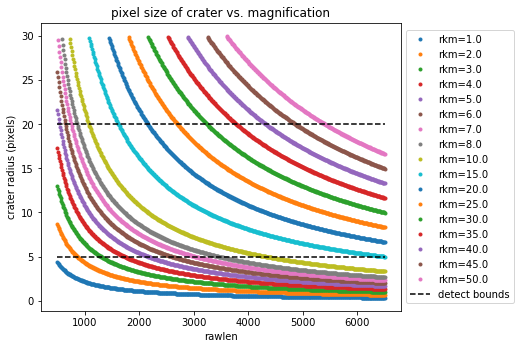

In [4]:
#automated
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.5,0.8])
rawlens = np.linspace(500,6500,500)
max_detect = 20
for rkm in [1,2,3,4,5,6,7,8,10,15,20,25,30,35,40,45,50]:
    bound, r = [], []
    for rawlen in rawlens:
        rpix = rkm/((rawlen/256.)*(np.pi / 180.0)*(1737.4/256))
        if rpix < 30:
            r.append(rpix)
            bound.append(rawlen)
    ax.plot(bound,r,'.',label='rkm=%.1f'%rkm)
ax.plot([min(rawlens),max(rawlens)],[max_detect,max_detect],'k--',label='detect bounds')
ax.plot([min(rawlens),max(rawlens)],[5,5],'k--')
leg = ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5),ncol=1)
ax.set_ylabel('crater radius (pixels)')
ax.set_xlabel('rawlen')
ax.set_title('pixel size of crater vs. magnification')
#plt.savefig('images/pix_vs_rawlen_mr6.png')

##

## Plot predictions for a given area
Run image_with_coordinates.py to get a few images that contains the region of interest, then plot

In [53]:
os.system("umount /Users/silburt/remotemount")
os.system("umount /Users/silburt/remotemount2")

256

In [3]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/final_data/ /Users/silburt/remotemount/")
dirssh = '/Users/silburt/remotemount'
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/r/rein/silburt/moon-craters/datasets/HEAD/ /Users/silburt/remotemount2/")
dirssh2 = '/Users/silburt/remotemount2'

In [4]:
dtype = 'train'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh,dtype), 'r')
#preds = h5py.File('%s/HEAD_%spreds_n30000_final.hdf5'%(dirssh2,dtype), 'r')[dtype]

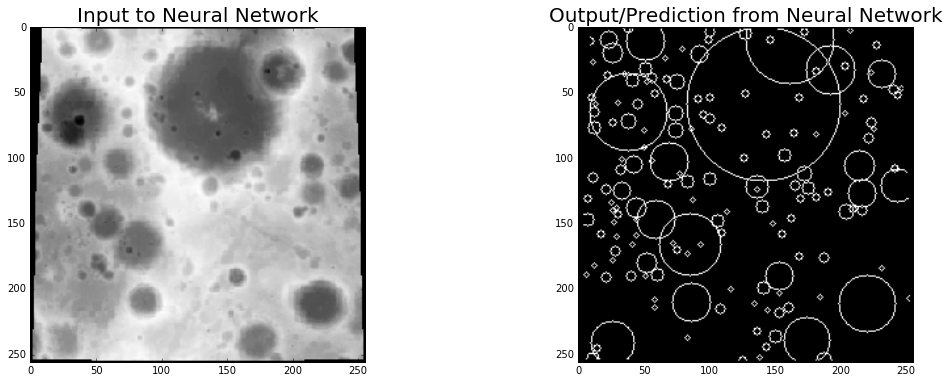

In [9]:
i=1
low,hi=0.01,1
img = imgs['input_images'][i]/255.
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

f, (ax1, ax2) = plt.subplots(1,2, figsize=[18, 6])
ax1.imshow(img,origin='upper',cmap="Greys_r")
ax1.set_title('Input to Neural Network',fontsize=20)
ax2.set_title('Output/Prediction from Neural Network',fontsize=20)
ax2.imshow(imgs['target_masks'][i],origin='upper',cmap="Greys_r")
plt.savefig("img-target_pair.pdf")

In [ ]:
def get_id(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

IOError: Can't read data (File read failed: time = fri dec 15 10:30:49 2017
, filename = '/users/silburt/remotemount/dev_images.hdf5', file descriptor = 67, errno = 5, error message = 'input/output error', buf = 0x7fa25c810008, total read size = 65536, bytes this sub-read = 65536, bytes actually read = 18446744073709551615, offset = 200680488)

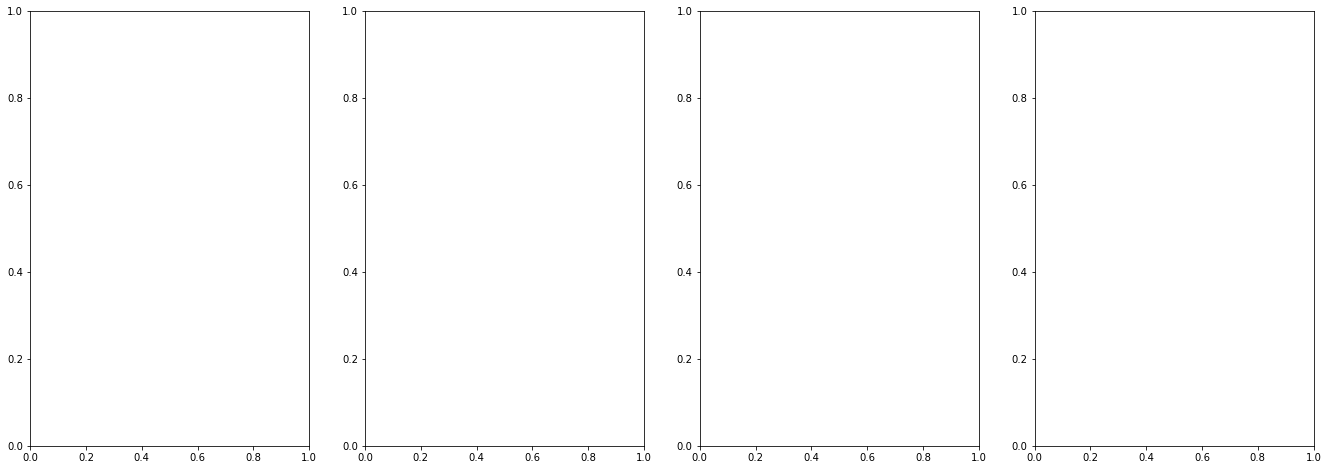

In [86]:
i=3062     #large craters: 49, 865, 1251, 1, 622, 6415 (shows 0.4 is bad, 0.5 is good)
#i=7148     #small craters: 7648, 538, 8028
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[23, 8])

img = imgs['input_images'][i]/255.
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = 0.1 + (img[img>0] - minn)*(0.9)/(maxx - minn) #linear re-scaling

pred = preds[i].copy()
#pred[pred < 0.1] = 0
#pred[pred >= 0.1] = 1

ax1.imshow(img,origin='upper',cmap="Greys_r")
ax2.imshow(img,origin='upper',cmap="Greys_r")
ax2.imshow(imgs['target_masks'][i],origin='upper', cmap="Greys_r",alpha=0.5)
#ax3.imshow(img,origin='upper',cmap="Greys_r")
ax3.imshow(pred,origin='upper', cmap="Greys_r",alpha=1)

ax1.set_title(imgs['longlat_bounds'][get_id(i)][...])
ax2.set_title('ground truth')
ax3.set_title('pred')
print('rawlen=%d'%(imgs['pix_bounds'][get_id(i)][2] - imgs['pix_bounds'][get_id(i)][0]))

########### extract crater dist ###########
minrad=6
maxrad=50
llt2=70
rt=1
template_thresh=0.5
target_thresh=0.1
coords = template_match_target(pred,minrad=minrad,maxrad=maxrad,longlat_thresh2=llt2,
                               rad_thresh=rt,template_thresh=template_thresh,
                               target_thresh=target_thresh)
cimg = cv2.cvtColor(pred.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
for c in coords:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,255,255),thickness=1)
ax4.imshow(img,origin='upper', cmap="Greys_r")
ax4.imshow(cimg,origin='upper', cmap="Greys_r",alpha=0.5)
ax4.set_title('pred + image')
########### extract crater dist ###########

plt.savefig('output_dir/images/large_circ_errs/img%d_tt%.2f.png'%(i,template_thresh))